In [1]:
# Importing necessary libraries 
import os
import cv2
from PIL import Image
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# path of image folder
path  = '/kaggle/input/pollen-grain-image-classification/'

names = [name.replace(' ', '_').split('_')[0] for name in os.listdir(path)]
classes = Counter(names)  #returns dictionary

print("Total number of images is {}".format(len(names)))

Total number of images is 790


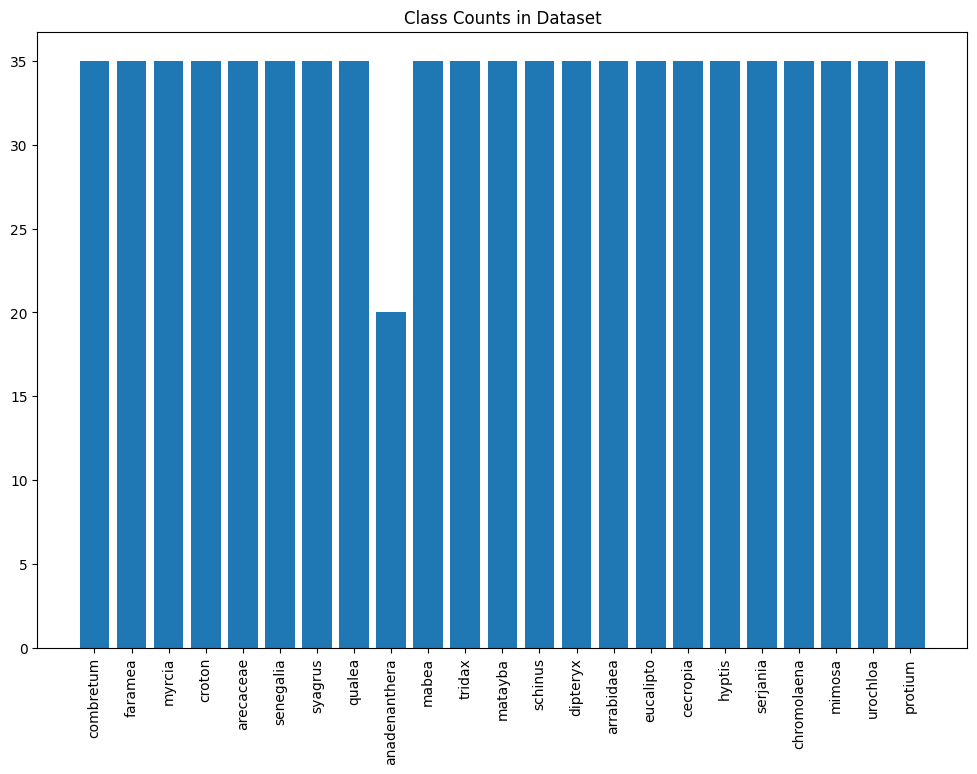

In [3]:
plt.figure(figsize = (12,8))
plt.title('Class Counts in Dataset')
plt.bar(*zip(*classes.items()))
plt.xticks(rotation='vertical')
plt.show()

In [4]:
path_class  = {key:[] for key in classes.keys()}

for name in os.listdir(path):
    key = name.replace(' ', '_').split('_')[0]
    path_class[key].append(path + name)

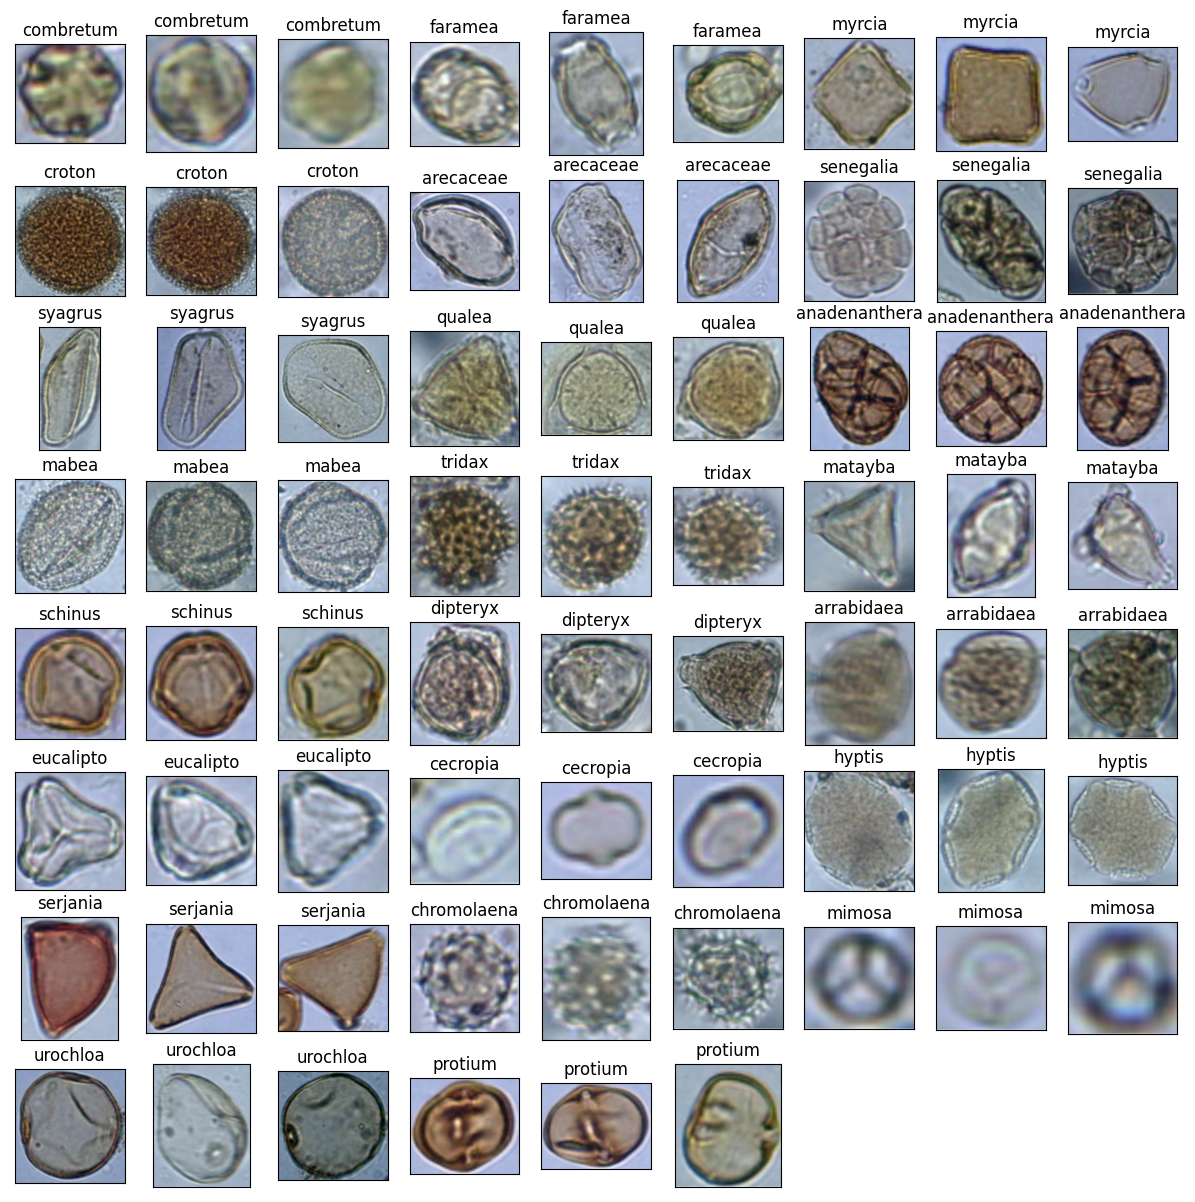

In [5]:
fig = plt.figure(figsize=(15, 15))
for i, key in enumerate(path_class.keys()):
    img1 = Image.open(path_class[key][0]) 
    img2 = Image.open(path_class[key][1]) 
    img3 = Image.open(path_class[key][2]) 

    ax = fig.add_subplot(8, 9,  3*i + 1, xticks=[], yticks=[])
    ax.imshow(img1)
    ax.set_title(key)
    
    ax = fig.add_subplot(8, 9,  3*i + 2, xticks=[], yticks=[])
    ax.imshow(img2)
    ax.set_title(key)

    ax = fig.add_subplot(8, 9,  3*i + 3, xticks=[], yticks=[])
    ax.imshow(img3)
    ax.set_title(key)
    

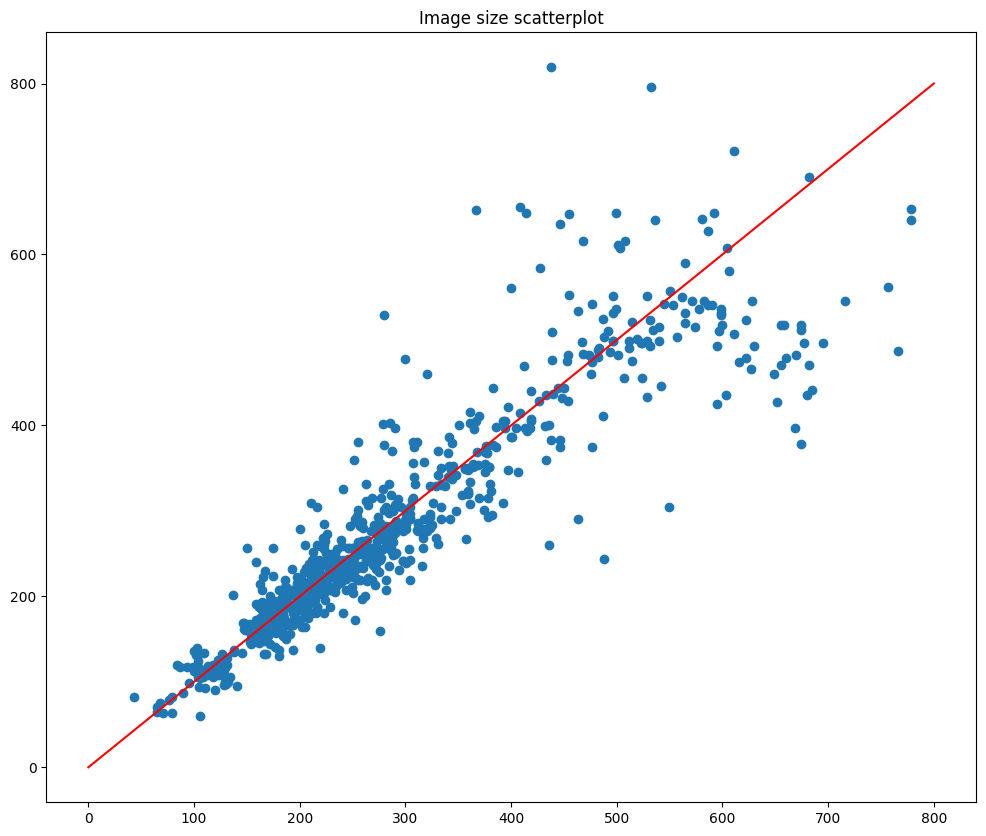

In [6]:
size = [cv2.imread(path + name).shape for name in os.listdir(path)]
x, y, _ = zip(*size)

fig = plt.figure(figsize=(12, 10))
# scatter plot
plt.scatter(x,y)
plt.title("Image size scatterplot")

# add diagonal red line 
plt.plot([0,800],[0,800], 'r')

In [7]:
def process_img(img, size = (128,128)):
    img = cv2.resize(img, size)  # resize image
    img = img/255                   # devide values to 255
    return img   

def plot_confusion_matrix(model, x, y, plot_title = ''):
    y_pred = model.predict(x)                            # get predictions on x using model
    predicted_categories = tf.argmax(y_pred, axis=1)     # get index of predicted category
    true_categories = tf.argmax(y, axis=1)               # get index of true category
    # create confusion matrix using sklearn
    cm = confusion_matrix(true_categories, predicted_categories)
    # create DataFrame from the confusion matrix. We retrieve labels from LabelEncoder.
    df_cm = pd.DataFrame(cm, index = le.classes_ ,  columns = le.classes_)
    # divide each row to its sum in the DataFrame to get normalized output
    df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)
    
    plt.figure(figsize = (15,12))
    plt.title(plot_title)
    sns.heatmap(df_cm, annot=True)

In [8]:
# Read all images and put in X variable, Y variable is class names
X, Y = [], []
for name  in os.listdir(path):
    img = cv2.imread(path + name)
    X.append(process_img(img))
    Y.append(name.replace(' ', '_').split('_')[0])

X = np.array(X)

In [9]:
le = LabelEncoder()
Y_le = le.fit_transform(Y)
Y_cat = np_utils.to_categorical(Y_le, 23)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_cat, test_size=0.285, stratify=Y_le)
print("Images in each class in Test set: {}".format(np.sum(Y_test, axis =0)))

Images in each class in Test set: [ 6. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10.]


In [11]:
input_shape =  X_train[0].shape
output_shape = 23

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, input_shape = input_shape, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters = 32, kernel_size = 2, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters = 64, kernel_size = 2, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters = 128, kernel_size = 2, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(500, activation = 'relu'))
model.add(Dense(150, activation = 'relu'))
model.add(Dense(output_shape, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [12]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
print('Model is Compiled!')

Model is Compiled!


In [13]:
datagener = ImageDataGenerator(
                rotation_range= 20,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                horizontal_flip = True,
                vertical_flip = True,)
# fit data generator
datagener.fit(X_train)

In [14]:
batch_size = 4
epochs = 500

model_path = 'cnn.hdf5'
callbecks = [EarlyStopping(monitor ='val_loss', patience = 20), 
             ModelCheckpoint(filepath = model_path, save_best_only = True)]


history = model.fit(
        datagener.flow(X_train, Y_train, batch_size=batch_size), 
        batch_size = batch_size, 
        steps_per_epoch = len(X_train) // batch_size,
        epochs = epochs,
        validation_data = (X_train, Y_train),
        callbacks = callbecks,
        verbose = 1)

Epoch 1/500
141/141 [==============================] - 16s 101ms/step - loss: 3.1424 - accuracy: 0.0372 - val_loss: 2.9467 - val_accuracy: 0.0940
Epoch 2/500
141/141 [==============================] - 14s 99ms/step - loss: 2.9091 - accuracy: 0.0816 - val_loss: 3.7247 - val_accuracy: 0.0461
Epoch 3/500
141/141 [==============================] - 13s 95ms/step - loss: 2.7594 - accuracy: 0.1028 - val_loss: 2.7767 - val_accuracy: 0.1135
Epoch 4/500
141/141 [==============================] - 13s 93ms/step - loss: 2.6258 - accuracy: 0.1383 - val_loss: 2.7954 - val_accuracy: 0.1223
Epoch 5/500
141/141 [==============================] - 14s 99ms/step - loss: 2.4681 - accuracy: 0.1436 - val_loss: 2.2296 - val_accuracy: 0.2713
Epoch 6/500
141/141 [==============================] - 13s 92ms/step - loss: 2.4009 - accuracy: 0.1844 - val_loss: 2.4883 - val_accuracy: 0.1613
Epoch 7/500
141/141 [==============================] - 13s 94ms/step - loss: 2.2612 - accuracy: 0.2394 - val_loss: 2.0513 - val_a

In [15]:
model.load_weights(model_path)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test set accuracy: {}'.format(score[1]))

Test set accuracy: 0.8318583965301514


8/8 [==============================] - 1s 77ms/step


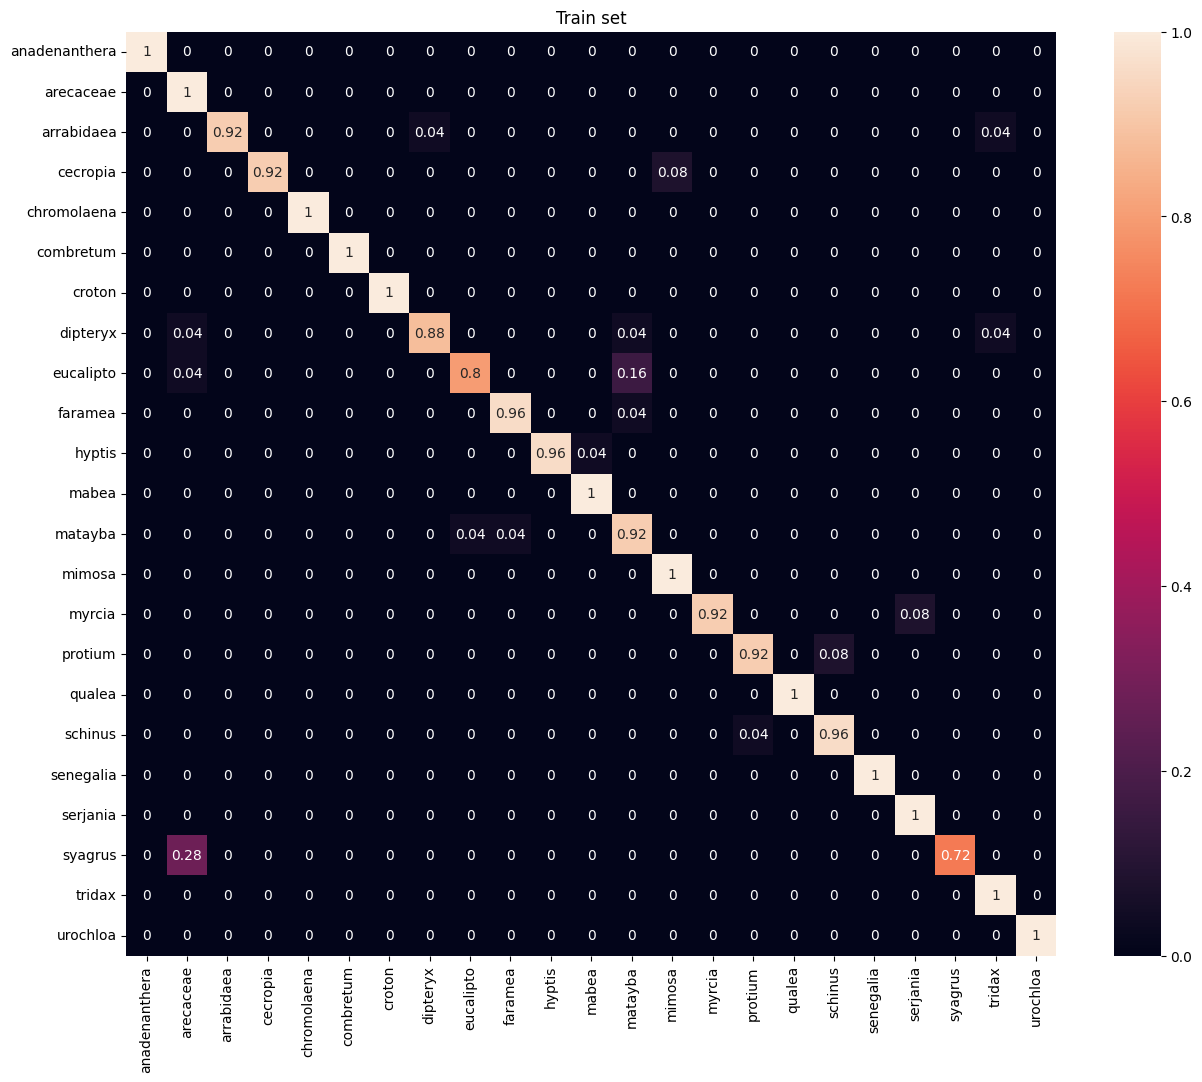

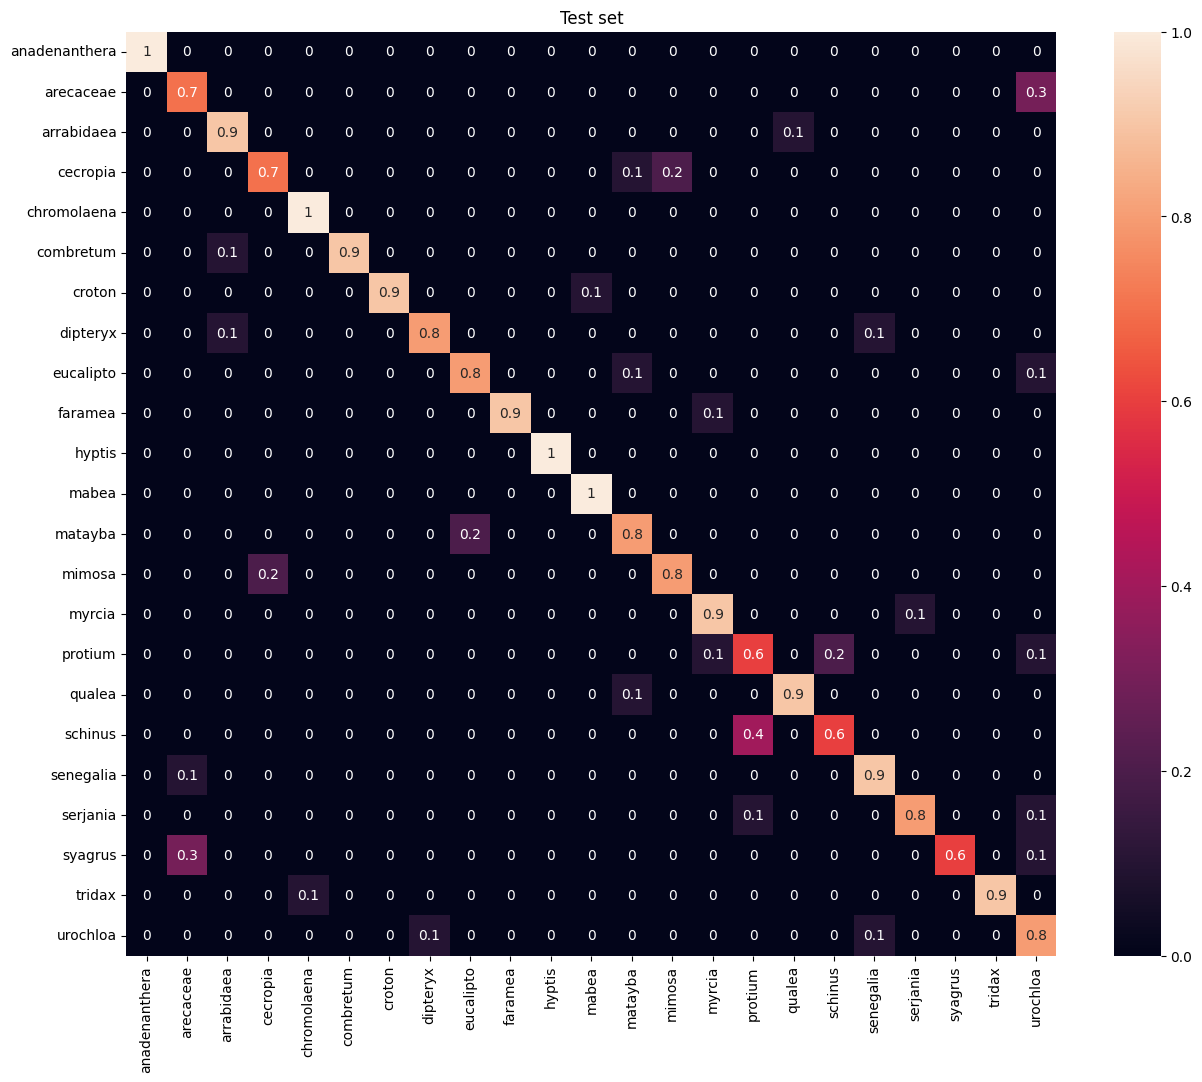

In [16]:
plot_confusion_matrix(model, X_train, Y_train, "Train set")
plot_confusion_matrix(model, X_test,  Y_test,  "Test set")

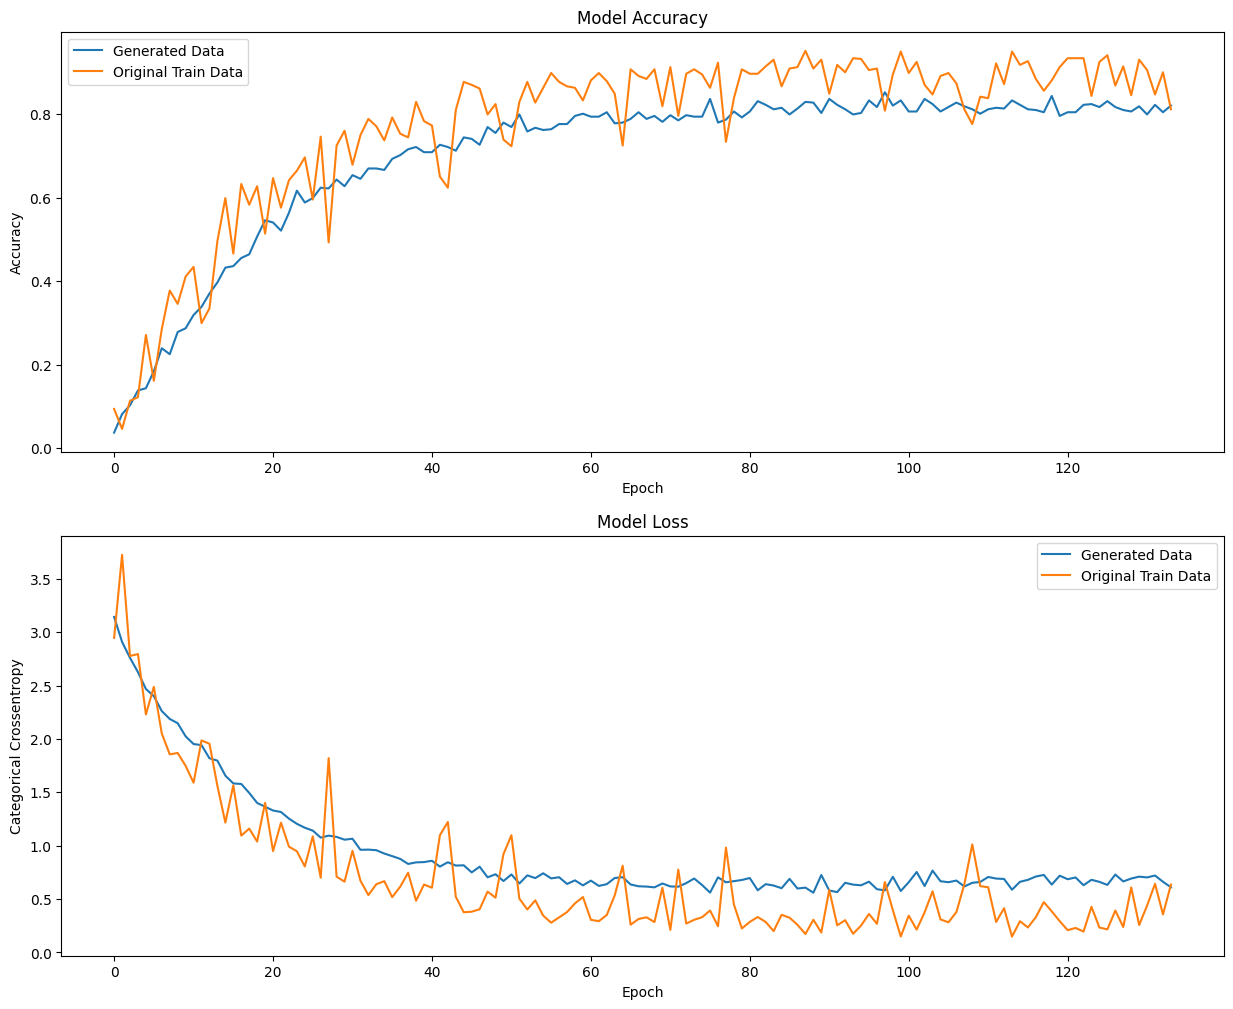

In [17]:
plt.figure(figsize = (15,12))     
   
plt.subplot(211)  
plt.title('Model Accuracy')  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Generated Data', 'Original Train Data'], loc='best')  
      
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Categorical Crossentropy')  
plt.xlabel('Epoch')  
plt.legend(['Generated Data', 'Original Train Data'], loc='best')  
plt.show()